<a href="https://colab.research.google.com/github/tiara070403/skripsi/blob/main/skripsilagi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn
# Import Library
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import pipeline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('/content/crawling.csv', index_col=0)
df_copy = df.copy()
df = df[['created_at', 'full_text']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5349 entries, 1858070162362204643 to 1230765438897815552
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  5349 non-null   object
 1   full_text   5349 non-null   object
dtypes: object(2)
memory usage: 125.4+ KB


In [ ]:
df['full_text'] = df['full_text'].astype(str).str.lower()
df['full_text'] = df['full_text'].replace('false', pd.NA)
df = df.dropna(subset=['full_text'])

In [ ]:
# Menghapus Duplikat
initial_duplicates = df.duplicated().sum()
df = df.drop_duplicates(subset=['full_text'])
print(f"Jumlah duplikat awal: {initial_duplicates}")
print(f"Jumlah duplikat setelah drop: {df.duplicated().sum()}")

Jumlah duplikat awal: 0
Jumlah duplikat setelah drop: 0


In [ ]:
# Menghapus baris dengan nilai null (setelah dropna subset)
df = df.dropna()
print(f"Jumlah nilai null setelah dropna: \n{df.isnull().sum()}")

Jumlah nilai null setelah dropna: 
created_at    0
full_text     0
dtype: int64


In [ ]:
# Case Folding
df['full_text'] = df['full_text'].str.lower()
print("\nDataFrame setelah Case Folding:")
print(df.head())


DataFrame setelah Case Folding:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643            lucu banget mahasiswa pencinta alam ini  
1846529554657239219  bejat mahasiswa pencinta alam di jambi 'genjot...  
1467691301155979267  @leonita_lestari ada perkoempoelan pentjinta a...  
1836014724523458593  [press release sowan ukm ke ukm unit pandu lin...  
1835164951125917967  [press release sowan ukm ke ukm unit pandu lin...  


In [ ]:
# Cleaning
def clean_twitter_text(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Menghapus mention
  text = re.sub(r'#\w+', '', text)          # Menghapus hashtag
  text = re.sub(r'RT[\s]+', '', text)        # Menghapus RT
  text = re.sub(r'https?://\S+', '', text)   # Menghapus URL
  text = re.sub(r'[^A-Za-z0-9 ]', '', text)  # Menghapus karakter non-alfanumerik kecuali spasi
  text = re.sub(r'\s+', ' ', text).strip()   # Menghapus spasi berlebih
  return text
df['full_text'] = df['full_text'].apply(clean_twitter_text)
print(f"\nShape setelah Cleaning: {df.shape}")
print("DataFrame setelah Cleaning:")
print(df.head())


Shape setelah Cleaning: (5246, 2)
DataFrame setelah Cleaning:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643            lucu banget mahasiswa pencinta alam ini  
1846529554657239219  bejat mahasiswa pencinta alam di jambi genjot ...  
1467691301155979267  ada perkoempoelan pentjinta alam yang lahir th...  
1836014724523458593  press release sowan ukm ke ukm unit pandu ling...  
1835164951125917967  press release sowan ukm ke ukm unit pandu ling...  


In [ ]:
# Filter Token Length
def filter_tokens_by_length(df, column, min_words, max_words):
    words_count = df[column].astype(str).apply(lambda x: len(x.split()))
    mask = (words_count >= min_words) & (words_count <= max_words)
    filtered_df = df[mask]
    return filtered_df
min_words = 3
max_words = 5500
df = filter_tokens_by_length(df, 'full_text', min_words, max_words)
print(f"\nShape setelah Filter Token Length: {df.shape}")
print("DataFrame setelah Filter Token Length:")
print(df.head())


Shape setelah Filter Token Length: (5170, 2)
DataFrame setelah Filter Token Length:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643            lucu banget mahasiswa pencinta alam ini  
1846529554657239219  bejat mahasiswa pencinta alam di jambi genjot ...  
1467691301155979267  ada perkoempoelan pentjinta alam yang lahir th...  
1836014724523458593  press release sowan ukm ke ukm unit pandu ling...  
1835164951125917967  press release sowan ukm ke ukm unit pandu ling...  


In [ ]:
# Normalisasi Data
norm = {'kekekekegiatanananan': 'kegiatan', 'kamucu': 'kamu', 'jutidak': 'tidak', 'lingkung': 'lingkungan',
    'berberberbersama': 'bersama', 'press release': 'siaran pers', 'ukamu': 'ukm',
    'kekekekegiatanananan': 'kegiatan', 'jutidak': 'tidak', 'lingkung': 'lingkungan',
    'berberberbersama': 'bersama', 'press release': 'siaran pers', 'ukamu': 'ukm',
    'giat': 'kegiatan', 'luring': 'luring', 'sekre': 'sekretariat',
    'mapala': 'mahasiswa pencinta alam', 'kocak': 'lucu', 'enak': 'enak',
    'bilang': 'bilang', 'sowan': 'mengunjungi', 'buka': 'membuka',
    'sampai': 'hingga', 'pukul': 'jam', 'sd': 'sampai', 'kapan': 'kapan',
    'mau': 'ingin', 'join': 'bergabung', 'sama': 'bersama', 'bisa': 'dapat',
    'bantu': 'membantu', 'mikir2': 'mikir', 'perkoempoelan': 'perkumpulan',
    'genjot': 'menyerang', 'wkwkw': 'hahaha', 'th': 'tahun', 'bejat': 'rusak',
    'pentjinta': 'pencinta', 'siaaapp': 'siap', 'okaaay': 'oke', 'udh': 'sudah',
    'ga': 'tidak', 'gaskeun': 'ayo', 'wowww': 'wow', 'haaayyuukkk': 'ayo',
    'yg': 'yang', 'wkwk': '', 'min': 'kak', 'malem': 'malam', 'malem2': 'malam',
    'sm': 'sama', 'dy': 'dia', 'lg': 'lagi', 'skrg': 'sekarang', 'ddpn': 'didepan',
    'makasi': 'makasih', 'pertamaz': 'pertamax', 'jg': 'juga', 'donk': 'dong',
    'ikutann': 'ikutan', 'banyakk': 'banyak', 'twt': 'tweet', 'mantaap': 'mantap',
    'juarak': 'juara', 'daridulu': 'dari dulu', 'siapp': 'siap', 'gamau': 'tidak mau',
    'sll': 'selalu', 'qu': 'aku', 'krn': 'karena', 'irii': 'iri', 'muluu': 'terus',
    'mada': 'masa', 'jgn': 'jangan', 'muluuu': 'terus', 'ntar': 'nanti',
    'awtnya': 'awetnya', 'gg': 'keren', 'kerennn': 'keren', 'bisaa': 'bisa',
    'gaaa': 'tidak', 'nyampe': 'sampai', 'lu': 'kamu', 'ikhlaaasss': 'ikhlas',
    'gak': 'tidak', 'klo': 'kalo', 'kyk': 'seperti', 'sbg': 'sebagai',
    'giat': 'kegiatan', 'luring': 'luring', 'sekre': 'sekretariat',
    'mapala': 'mahasiswa pencinta alam', 'kocak': 'lucu', 'enak': 'enak',
    'bilang': 'bilang', 'sowan': 'mengunjungi', 'buka': 'membuka',
    'sampai': 'hingga', 'pukul': 'jam', 'sd': 'sampai', 'kapan': 'kapan',
    'mau': 'ingin', 'join': 'bergabung', 'sama': 'bersama', 'bisa': 'dapat',
    'bantu': 'membantu', 'mikir2': 'mikir', 'perkoempoelan': 'perkumpulan',
    'genjot': 'menyerang', 'wkwkw': 'hahaha', 'th': 'tahun', 'bejat': 'rusak',
    'pentjinta': 'pencinta', 'siaaapp': 'siap', 'okaaay': 'oke', 'udh': 'sudah',
    'ga': 'tidak', 'gaskeun': 'ayo', 'wowww': 'wow', 'haaayyuukkk': 'ayo',
    'yg': 'yang', 'wkwk': '', 'min': 'kak', 'malem': 'malam', 'malem2': 'malam',
    'sm': 'sama', 'dy': 'dia', 'lg': 'lagi', 'skrg': 'sekarang', 'ddpn': 'didepan',
    'makasi': 'makasih', 'pertamaz': 'pertamax', 'jg': 'juga', 'donk': 'dong',
    'ikutann': 'ikutan', 'banyakk': 'banyak', 'twt': 'tweet', 'mantaap': 'mantap',
    'juarak': 'juara', 'daridulu': 'dari dulu', 'siapp': 'siap', 'gamau': 'tidak mau',
    'sll': 'selalu', 'qu': 'aku', 'krn': 'karena', 'irii': 'iri', 'muluu': 'terus',
    'mada': 'masa', 'jgn': 'jangan', 'muluuu': 'terus', 'ntar': 'nanti',
    'awtnya': 'awetnya', 'gg': 'keren', 'kerennn': 'keren', 'bisaa': 'bisa',
    'gaaa': 'tidak', 'nyampe': 'sampai', 'lu': 'kamu', 'ikhlaaasss': 'ikhlas',
    'gak': 'tidak', 'klo': 'kalo', 'kyk': 'seperti', 'sbg': 'sebagai', 'kamucu': 'kamu'}
def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text
df['full_text'] = df['full_text'].apply(lambda x: normalisasi(x))
print("\nNormalisasi:")
print(df.head())


Normalisasi:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643                kamu banget mahasiswa pencinta alam  
1846529554657239219  rusak mahasiswa pencinta alam jambi menyerang ...  
1467691301155979267  perkumpulan pencinta alam lahir tahun 1953 did...  
1836014724523458593  siaran pers mengunjungi ukm ukm unit pandu lin...  
1835164951125917967  siaran pers mengunjungi ukm ukm unit pandu lin...  


In [ ]:
# Stopwords Removal
more_stop_words = ['anjayyy', 'gtgtgt']
stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)
def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text
df['full_text'] = df['full_text'].apply(lambda x: stopword(x))
print("\nStopwords Removal:")
print(df.head())


Stopwords Removal:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643                kamu banget mahasiswa pencinta alam  
1846529554657239219  rusak mahasiswa pencinta alam jambi menyerang ...  
1467691301155979267  perkumpulan pencinta alam lahir tahun 1953 did...  
1836014724523458593  siaran pers mengunjungi ukm ukm unit pandu lin...  
1835164951125917967  siaran pers mengunjungi ukm ukm unit pandu lin...  


In [ ]:
# Tokenisasi
tokenized_for_stemming = df['full_text'].apply(lambda x: x.split())
print("\nTokenisasi:")
print(tokenized_for_stemming.head())


Tokenisasi:
conversation_id_str
1858070162362204643            [kamu, banget, mahasiswa, pencinta, alam]
1846529554657239219    [rusak, mahasiswa, pencinta, alam, jambi, meny...
1467691301155979267    [perkumpulan, pencinta, alam, lahir, tahun, 19...
1836014724523458593    [siaran, pers, mengunjungi, ukm, ukm, unit, pa...
1835164951125917967    [siaran, pers, mengunjungi, ukm, ukm, unit, pa...
Name: full_text, dtype: object


In [ ]:
df.shape

(5170, 2)

In [ ]:
# Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming_text(list_of_tokens):
  stemmed_tokens = [stemmer.stem(w) for w in list_of_tokens]
  return " ".join(stemmed_tokens)
df['full_text'] = tokenized_for_stemming.apply(stemming_text)
print("\nDataFrame Stemming:")
df.to_csv('/content/stemming10.csv', index=False)
print(df.head())
print("\nDataframe setelah preprocessing disimpan ke /content/stemming10.csv")
print(f"Final DataFrame Shape: {df.shape}")


DataFrame Stemming:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643                   kamu banget mahasiswa cinta alam  
1846529554657239219  rusak mahasiswa cinta alam jambi serang paksa ...  
1467691301155979267  kumpul cinta alam lahir tahun 1953 diri awibow...  
1836014724523458593  siar pers unjung ukm ukm unit pandu lingkuntid...  
1835164951125917967  siar pers unjung ukm ukm unit pandu lingkuntid...  

Dataframe setelah preprocessing disimpan ke /content/stemming10.csv
Final DataFra

In [ ]:
# Labeling
print("\nLabeling")
df = pd.read_csv('/content/stemming10.csv')
classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")
def prediksi_sentimen(teks):
    if not isinstance(teks, str) or not teks.strip():
        return 'neutral'
    try:
        hasil = classifier(teks)
        return hasil[0]['label']
    except Exception as e:
        print(f"Error predicting sentiment for text: '{teks[:50]}...' - {e}")
        return 'neutral'
print("\nMemulai proses Labeling")
df['sentimen'] = df['full_text'].apply(prediksi_sentimen)
print("Labeling selesai.")
df.to_csv('/content/labeling10.csv', index=False)
print("\nDataframe dengan sentimen disimpan ke /content/labeling10.csv")


Labeling


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Memulai proses Labeling
Labeling selesai.

Dataframe dengan sentimen disimpan ke /content/labeling10.csv


In [ ]:
sentimen_counts = df.sentimen.value_counts()
print("\nDistribusi Sentimen:")
print(sentimen_counts)
print(f"\nFinal DataFrame Shape: {df.shape}")


Distribusi Sentimen:
sentimen
neutral     2180
positive    2089
negative     901
Name: count, dtype: int64

Final DataFrame Shape: (5170, 3)



Visualisasi


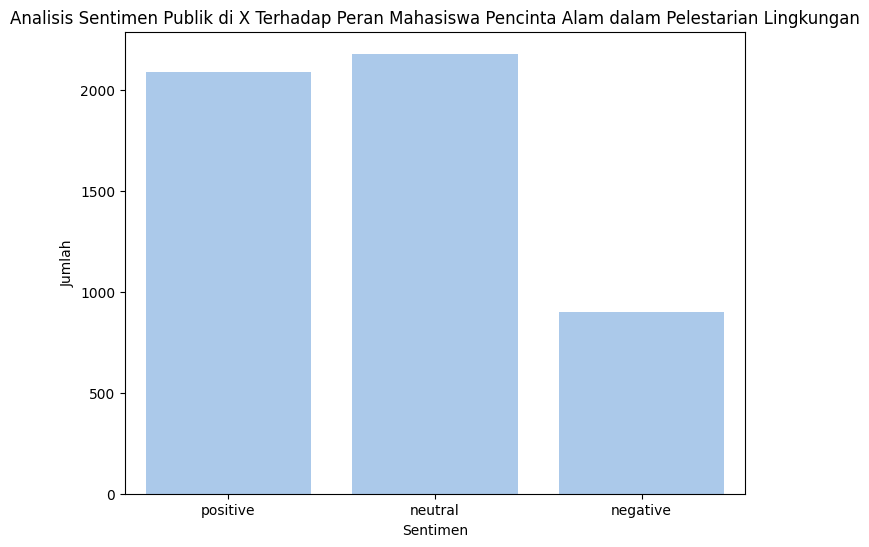

In [ ]:
# Visualisasi
print("\nVisualisasi")
sns.set_palette("pastel")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentimen', data=df)
plt.title('Analisis Sentimen Publik di X Terhadap Peran Mahasiswa Pencinta Alam dalam Pelestarian Lingkungan')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [ ]:
data_positif = df[df['sentimen'] == 'positive']
data_negatif = df[df['sentimen'] == 'negative']
data_netral = df[df['sentimen'] == 'neutral']

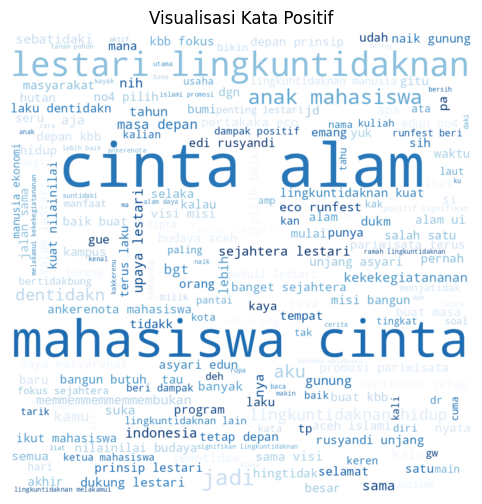

In [ ]:
# Word Cloud Positif
if not data_positif.empty:
    all_text_s1 = ' '.join(word for word in data_positif["full_text"].dropna())
    if all_text_s1:
        wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
        plt.figure(figsize=(9, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Visualisasi Kata Positif")
        plt.margins(x=0, y=0)
        plt.show()

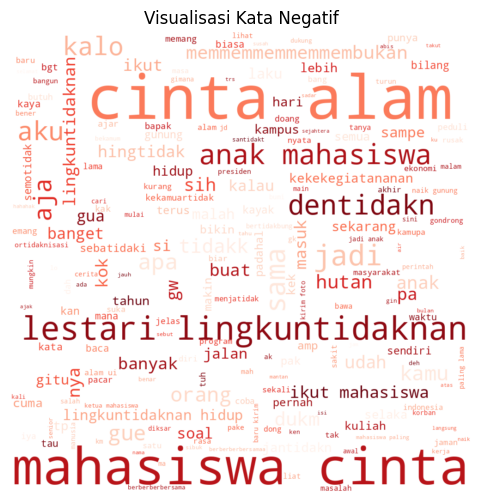

In [ ]:
# Word Cloud Negatif
if not data_negatif.empty:
    all_text_s0 = ' '.join(word for word in data_negatif["full_text"].dropna())
    if all_text_s0:
        wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
        plt.figure(figsize=(9, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Visualisasi Kata Negatif")
        plt.margins(x=0, y=0)
        plt.show()

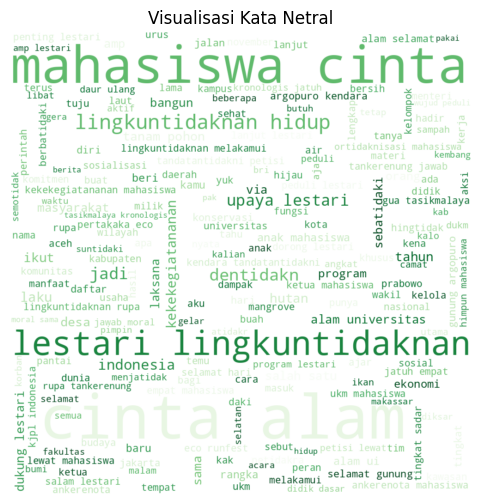

In [ ]:
# Word Cloud Netral
if not data_netral.empty:
    all_text_s2 = ' '.join(word for word in data_netral["full_text"].dropna())
    if all_text_s2:
        wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s2)
        plt.figure(figsize=(9, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Visualisasi Kata Netral")
        plt.margins(x=0, y=0)
        plt.show()

In [ ]:
# Pembagian Data
print("\nPembagian Data")
x = df.full_text
y = df.sentimen


Pembagian Data


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
print('\nBanyak data x_train :',len(x_train))
print('Banyak data x_test  :',len(x_test))
print('Banyak data y_train :',len(y_train))
print('Banyak data y_test  :',len(y_test))


Banyak data x_train : 4136
Banyak data x_test  : 1034
Banyak data y_train : 4136
Banyak data y_test  : 1034


In [ ]:
print("\nMENAMPILKAN DATA TEST DAN TRAIN")
print("\ndata pertama dari x_train (teks yang sudah diproses):")
print(x_train.head().to_string())
print("\ndata pertama dari x_test (teks yang sudah diproses):")
print(x_test.head().to_string())
print("\ndata pertama dari y_train (label sentimen):")
print(y_train.head())
print("\ndata pertama dari y_test (label sentimen):")
print(y_test.head())


MENAMPILKAN DATA TEST DAN TRAIN

data pertama dari x_train (teks yang sudah diproses):
841          hahahak mahasiswa cinta alam soundtrack nyaa
3091    menjatidak lingkuntidaknan lestari hidup kuran...
613     koran jastis unit kekekegiatananan mahasiswa r...
2659    edi rusyandi unjang asyari edun pilih baik bua...
3568    tilik adab lestari lingkuntidaknan kali pesank...

data pertama dari x_test (teks yang sudah diproses):
2479                                    adhyaksa dah laut
53                         mahasiswa cinta alam ohh bener
2515    dana memmemmemmemmembantuan disakamurkan denti...
563     soal tinkereni cantik pokok liat beda aja sama...
1342    aku baca au wattpad cerita pendakianmahasiswa ...

data pertama dari y_train (label sentimen):
841     positive
3091    positive
613      neutral
2659    positive
3568    positive
Name: sentimen, dtype: object

data pertama dari y_test (label sentimen):
2479    positive
53      positive
2515     neutral
563     positive
1342  

In [ ]:
print(f"\nUkuran x_train: {x_train.shape}")
print(f"Ukuran x_test: {x_test.shape}")
print(f"Ukuran y_train: {y_train.shape}")
print(f"Ukuran y_test: {y_test.shape}")


Ukuran x_train: (4136,)
Ukuran x_test: (1034,)
Ukuran y_train: (4136,)
Ukuran y_test: (1034,)


In [ ]:
# Pelatihan dan Evaluasi Model Naive Bayes dengan Hyperparameter Tuning
print("\nPelatihan dan Evaluasi Model Naive Bayes")
# Pipeline untuk Naive Bayes
pipeline_nb = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])
# Parameter Grid untuk GridSearchCV
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__max_features': [5000, 10000, 15000],
    'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
}
# Inisialisasi GridSearchCV
grid_search_nb = GridSearchCV(pipeline_nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
print("\nMemulai GridSearchCV untuk Naive Bayes")
grid_search_nb.fit(x_train, y_train)
print("\nGridSearchCV selesai.")
print(f"Best parameters found: {grid_search_nb.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_nb.best_score_:.4f}")



Pelatihan dan Evaluasi Model Naive Bayes

Memulai GridSearchCV untuk Naive Bayes
Fitting 5 folds for each of 45 candidates, totalling 225 fits

GridSearchCV selesai.
Best parameters found: {'classifier__alpha': 0.1, 'vectorizer__max_features': 15000, 'vectorizer__ngram_range': (1, 2)}
Best cross-validation accuracy: 0.6642


In [ ]:
# Pelatihan Model Naive Bayes dengan TF-IDF (Menggunakan Parameters) ---
print("\nPelatihan Model Naive Bayes dengan TF-IDF (menggunakan parameters dari GridSearchCV)")
# Menggunakan parameters oleh GridSearchCV
best_max_features = grid_search_nb.best_params_['vectorizer__max_features']
best_ngram_range = grid_search_nb.best_params_['vectorizer__ngram_range']
best_alpha = grid_search_nb.best_params_['classifier__alpha']
tfidf_vectorizer = TfidfVectorizer(max_features=best_max_features, ngram_range=best_ngram_range)
naive_bayes_classifier = MultinomialNB(alpha=best_alpha)
model_naive_bayes = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', naive_bayes_classifier)
])

# Latih model Naive Bayes dengan parameter
model_naive_bayes.fit(x_train, y_train)
print("Model Naive Bayes berhasil dilatih dengan parameter.")
print("\nMENAMPILKAN REPRESENTASI TF-IDF DAN PROBABILITAS")
trained_tfidf_vectorizer = model_naive_bayes.named_steps['vectorizer']
X_train_tfidf_transformed = trained_tfidf_vectorizer.transform(x_train)
X_test_tfidf_transformed = trained_tfidf_vectorizer.transform(x_test)
print(f"\nShape TF-IDF dari x_train: {X_train_tfidf_transformed.shape}")
print(f"Shape TF-IDF dari x_test: {X_test_tfidf_transformed.shape}")
print("\nbaris pertama dari matriks TF-IDF x_train (sparse format):")
print(X_train_tfidf_transformed[:10])

print("\nJumlah fitur (kata unik) yang dipelajari oleh TF-IDF Vectorizer:", len(trained_tfidf_vectorizer.get_feature_names_out()))
print("\nBeberapa fitur (kata) pertama yang dipelajari oleh TF-IDF Vectorizer:")
print(trained_tfidf_vectorizer.get_feature_names_out()[:20])
# Untuk melihat TF-IDF dari sebuah teks
if not x_train.empty:
    sample_text_train = x_train.iloc[0]
    sample_tfidf_train = trained_tfidf_vectorizer.transform([sample_text_train])
    print(f"\nTF-IDF untuk contoh teks pertama dari x_train ('{sample_text_train[:50]}...'):")
    print(sample_tfidf_train.toarray())
    feature_names = trained_tfidf_vectorizer.get_feature_names_out()
    print("Fitur dengan bobot non-nol untuk contoh teks ini:")
    non_zero_cols = sample_tfidf_train.nonzero()[1]
    for col_idx in non_zero_cols:
        print(f"  {feature_names[col_idx]}: {sample_tfidf_train[0, col_idx]:.4f}")
print("\n--- Probabilitas Prediksi")
y_proba_nb = model_naive_bayes.predict_proba(x_test)
print("\nProbabilitas prediksi untuk 10 sampel pertama dari x_test:")
proba_df = pd.DataFrame(y_proba_nb[:5], columns=model_naive_bayes.classes_)
print(proba_df)
print("\nContoh probabilitas untuk satu teks dari x_test:")
if not x_test.empty:
    sample_text_test = x_test.iloc[0]
    sample_proba = model_naive_bayes.predict_proba([sample_text_test])
    print(f"Teks: '{sample_text_test[:50]}...'")
    print(f"Probabilitas: {sample_proba[0]}")
    # Menampilkan probabilitas dengan label kelas
    for i, class_label in enumerate(model_naive_bayes.classes_):
        print(f"  {class_label}: {sample_proba[0][i]:.4f}")
    print(f"Prediksi kelas: {model_naive_bayes.predict([sample_text_test])[0]}")


Pelatihan Model Naive Bayes dengan TF-IDF (menggunakan parameters dari GridSearchCV)
Model Naive Bayes berhasil dilatih dengan parameter.

MENAMPILKAN REPRESENTASI TF-IDF DAN PROBABILITAS

Shape TF-IDF dari x_train: (4136, 15000)
Shape TF-IDF dari x_test: (1034, 15000)

baris pertama dari matriks TF-IDF x_train (sparse format):
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 229 stored elements and shape (10, 15000)>
  Coords	Values
  (0, 482)	0.22252746577311724
  (0, 2788)	0.23087722251539677
  (0, 2792)	0.235352904018994
  (0, 8109)	0.8541993183358975
  (0, 10459)	0.23346464969723685
  (0, 10466)	0.24005005221043133
  (1, 1279)	0.1760034058906274
  (1, 1329)	0.18052076418204127
  (1, 1994)	0.18052076418204127
  (1, 1997)	0.24000580791029474
  (1, 5904)	0.1110447855971981
  (1, 5929)	0.2287355443560637
  (1, 6778)	0.2287355443560637
  (1, 6779)	0.24000580791029474
  (1, 8246)	0.20277399509111158
  (1, 8269)	0.2145366914955571
  (1, 8722)	0.09401419331943021
  (1, 9365)

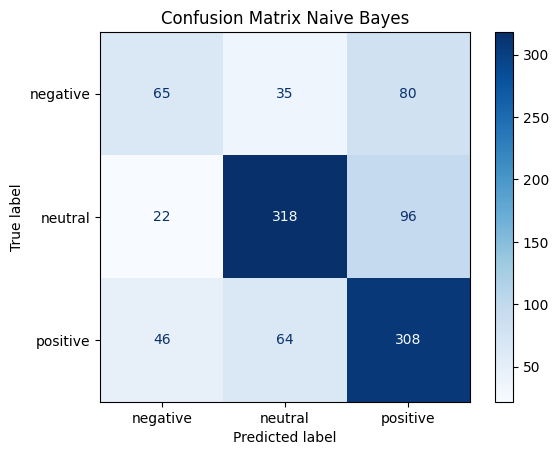

Classification Report (Naive Bayes):
               precision    recall  f1-score   support

    negative       0.49      0.36      0.42       180
     neutral       0.76      0.73      0.75       436
    positive       0.64      0.74      0.68       418

    accuracy                           0.67      1034
   macro avg       0.63      0.61      0.61      1034
weighted avg       0.66      0.67      0.66      1034


INFORMASI INTERNAL MODEL NAIVE BAYES

Ukuran Vocabulary: 15000

Shape Matriks TF-IDF (x_train): (4136, 15000)

Nama Kelas (Sentimen): ['negative' 'neutral' 'positive']

Log Probabilitas Prior Kelas:
  Log P(negative): -1.7468
  Log P(neutral): -0.8635
  Log P(positive): -0.9063

Shape Log Probabilitas Likelihood Fitur: (3, 15000)

10 Kata Teratas dengan Probabilitas Tertinggi per Kelas:
  Kelas 'negative':
    - mahasiswa (Log Prob: -4.7567)
    - cinta (Log Prob: -4.7855)
    - cinta alam (Log Prob: -4.8005)
    - mahasiswa cinta (Log Prob: -4.8005)
    - alam (Log Prob: -

In [ ]:
# Evaluasi Model Naive Bayes
y_pred_nb = model_naive_bayes.predict(x_test)

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=model_naive_bayes.classes_)
disp_nb.plot(cmap='Blues')
plt.title('Confusion Matrix Naive Bayes')
plt.show()

# Classification Report
matrix_nb = classification_report(y_test, y_pred_nb)
print('Classification Report (Naive Bayes):\n', matrix_nb)

# Informasi Internal Model Naive Bayes
print("\nINFORMASI INTERNAL MODEL NAIVE BAYES")
trained_vectorizer = model_naive_bayes.named_steps['vectorizer']
trained_classifier = model_naive_bayes.named_steps['classifier']
vocabulary = trained_vectorizer.vocabulary_
print("\nUkuran Vocabulary:", len(vocabulary))
X_train_tfidf_transformed_for_info = trained_vectorizer.transform(x_train) # Re-transform for info if needed
print(f"\nShape Matriks TF-IDF (x_train): {X_train_tfidf_transformed_for_info.shape}")
class_labels = trained_classifier.classes_
print("\nNama Kelas (Sentimen):", class_labels)
log_prior_classes = trained_classifier.class_log_prior_
print("\nLog Probabilitas Prior Kelas:")
for i, label in enumerate(class_labels):
      print(f"  Log P({label}): {log_prior_classes[i]:.4f}")
log_likelihood_features = trained_classifier.feature_log_prob_
print(f"\nShape Log Probabilitas Likelihood Fitur: {log_likelihood_features.shape}")
print("\n10 Kata Teratas dengan Probabilitas Tertinggi per Kelas:")
feature_names = trained_vectorizer.get_feature_names_out()
for i, class_label in enumerate(class_labels):
    top_10_indices = log_likelihood_features[i, :].argsort()[-10:][::-1]
    top_10_words = [feature_names[idx] for idx in top_10_indices]
    top_10_probs = [f"{log_likelihood_features[i, idx]:.4f}" for idx in top_10_indices]
    print(f"  Kelas '{class_label}':")
    for j in range(10):
        print(f"    - {top_10_words[j]} (Log Prob: {top_10_probs[j]})")


In [ ]:
# Pengujian Model
print("\nPengujian Model Naive")
def classify_text_with_naive_bayes(input_text):

    if not isinstance(input_text, str):
        input_text = str(input_text)
    processed_text = input_text.lower()
    processed_text = clean_twitter_text(processed_text)
    processed_text = normalisasi(processed_text)
    processed_text = stopword(processed_text)

    processed_text_tokens = processed_text.split()
    processed_text = stemming_text(processed_text_tokens)

    prediction = model_naive_bayes.predict([processed_text])

    prediction_proba = model_naive_bayes.predict_proba([processed_text])
    return prediction[0], prediction_proba[0]
input_text_user = input("\nMasukkan teks yang ingin diklasifikasikan oleh Naive Bayes: ")
results_nb_class, results_nb_proba = classify_text_with_naive_bayes(input_text_user)
print("Input teks :", input_text_user)
print(f"Hasil Klasifikasi (Multinomial Naive Bayes): {results_nb_class}")
print("Probabilitas untuk setiap kelas:")
for i, class_label in enumerate(model_naive_bayes.classes_):
    print(f"  {class_label}: {results_nb_proba[i]:.4f}")


Pengujian Model Naive

Masukkan teks yang ingin diklasifikasikan oleh Naive Bayes: gondrong
Input teks : gondrong
Hasil Klasifikasi (Multinomial Naive Bayes): negative
Probabilitas untuk setiap kelas:
  negative: 0.4734
  neutral: 0.1893
  positive: 0.3372
